Open the mask file --> slice area of interest.

Using scipy.convolve, check neighbours of mask file (in 8 directions) --> output coastal cells

## Importing packages

In [1]:
from datetime import date 
from datetime import datetime
import glob
import numpy as np
from scipy import signal
import scipy.ndimage as ndimage
from scipy.ndimage import convolve
from scipy.ndimage.measurements import label, find_objects
import xarray as xr

## Opening the mask file

In [14]:
# NE coast of Tasmania

ds = xr.open_dataset('/g/data/e14/cp3790/Charuni/static_era5.nc').sel(longitude=slice(147.0, 149.0), latitude=slice(-40.0, -42.0))
mask = xr.where(ds.lsm==0, 0, 1)

In [15]:
mask

<xarray.DataArray 'lsm' (time: 1, latitude: 9, longitude: 9)>
array([[[0, 0, 1, 1, 1, 1, 1, 0, 0],
        [0, 0, 0, 1, 1, 1, 1, 0, 0],
        [0, 0, 0, 1, 1, 1, 1, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 0, 0]]])
Coordinates:
  * longitude  (longitude) float32 147.0 147.25 147.5 ... 148.5 148.75 149.0
  * latitude   (latitude) float32 -40.0 -40.25 -40.5 ... -41.5 -41.75 -42.0
  * time       (time) datetime64[ns] 2000-01-01

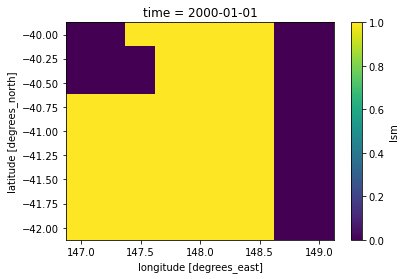

In [54]:
mask.plot()

## Finding coastal cells

k is an array of weights, with the same number of dimensions as input

In [16]:
k =([[[1, 1, 1],
    [1, 0, 1],
    [1, 1, 1]]])

input array 'mask' is convolved with 'k', mode='constant' which ensures that the input is extended by filling all values beyond the edge with the same constant value

In [17]:
c = convolve(mask, k, mode='constant')

In [18]:
c

array([[[0, 1, 2, 4, 5, 5, 3, 2, 0],
        [0, 1, 4, 6, 8, 8, 5, 3, 0],
        [2, 3, 5, 6, 8, 8, 5, 3, 0],
        [3, 5, 6, 7, 8, 8, 5, 3, 0],
        [5, 8, 8, 8, 8, 8, 5, 3, 0],
        [5, 8, 8, 8, 8, 8, 5, 3, 0],
        [5, 8, 8, 8, 8, 8, 5, 3, 0],
        [5, 8, 8, 8, 8, 8, 5, 3, 0],
        [3, 5, 5, 5, 5, 5, 3, 2, 0]]])

coastal array is 1 when the mask==1 and the sum of neighbouring cells is < 8 (which means at least one cell is neighbouring a 0 (or sea grid cell)

In [19]:
coastal = np.logical_and(mask == 1, c < 8)

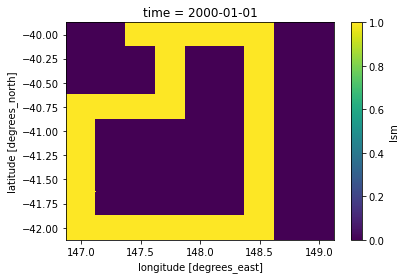

In [65]:
coastal.astype(int).plot()

## Anomaly datasets

In [21]:
# surface air temperature anomalies
tasa = xr.open_dataset('/g/data/e14/cp3790/Charuni/surface_air_temp_anomaly.nc').sel(time=slice('2016', '2018'), longitude=slice(147.0, 149.0), latitude=slice(-40.0, -42.0))

In [71]:
anom = tasa.anomaly
anom

<xarray.DataArray 'anomaly' (time: 1096, latitude: 9, longitude: 9)>
array([[[ 2.939394e+00,  2.905128e+00, ...,  3.010908e+00,  3.361446e+00],
        [ 2.953076e+00,  2.788052e+00, ...,  2.787050e+00,  3.065786e+00],
        ...,
        [ 4.220390e-02, -2.185173e-01, ...,  1.662238e+00,  1.629166e+00],
        [-4.119635e-01, -1.062887e+00, ...,  1.602727e+00,  1.511135e+00]],

       [[ 1.315797e+00,  1.275266e+00, ...,  5.883293e-01,  4.222393e-01],
        [ 1.344035e+00,  1.258168e+00, ...,  6.156368e-01,  4.590359e-01],
        ...,
        [-3.555281e+00, -3.651695e+00, ...,  2.634277e-01,  4.185677e-02],
        [-3.729027e+00, -4.420980e+00, ...,  1.987772e-01,  3.467560e-03]],

       ...,

       [[ 2.406899e+00,  2.349280e+00, ...,  3.045853e+00,  2.892363e+00],
        [ 2.547693e+00,  2.501102e+00, ...,  2.932821e+00,  2.946949e+00],
        ...,
        [ 5.354118e-02, -4.624901e-01, ...,  2.116341e+00,  2.175816e+00],
        [ 9.243107e-01, -3.936062e-01, ...,  2.005618e+00,  1.967132e+00]],

       [[ 2.087268e+00,  2.134298e+00, ...,  2.812902e+00,  2.815596e+00],
        [ 2.103988e+00,  2.199645e+00, ...,  2.891039e+00,  2.990070e+00],
        ...,
        [-1.087494e-01, -5.778313e-01, ...,  2.514325e+00,  2.765407e+00],
        [ 1.935948e+00,  3.955555e-01, ...,  2.419798e+00,  2.718855e+00]]],
      dtype=float32)
Coordinates:
  * longitude  (longitude) float32 147.0 147.25 147.5 ... 148.5 148.75 149.0
  * latitude   (latitude) float32 -40.0 -40.25 -40.5 ... -41.5 -41.75 -42.0
  * time       (time) datetime64[ns] 2016-01-01 2016-01-02 ... 2018-12-31

In [23]:
def fix(ds):
    # This function makes the original data array repeatable so that it matches with the shape of the other data array.

    trial = ds
    i = 0
    while i < 1096:  # <-- Here, 1096 corresponds to the timesteps in land dataset 
        trial = xr.concat([trial, ds], 'time')
        i+=1
    trial = trial.isel(time = slice(0,1096))
    # to specify the dates/time 
    trial.coords['time'] = np.arange(date(2016,1,1).toordinal(),date(2018,12,31).toordinal()+1) 
    
    t = np.arange(date(2016,1,1).toordinal(),date(2018,12,31).toordinal()+1)
    dates = [date.fromordinal(tt.astype(int)) for tt in t]
    
    trial.coords['time'] = dates

    return trial

In [25]:
new_coastal = fix(coastal)  # new_coastal will now have the same shape as anom 

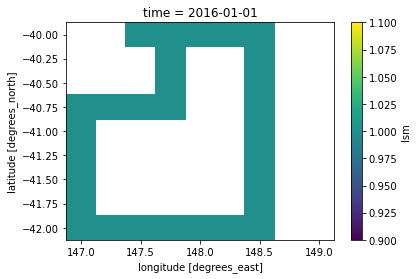

In [66]:
coast_grids = new_coastal.where(new_coastal != 0)
coast_grids
coast_grids.isel(time=0).plot()

In [27]:
coast_sel_stacked = coast_grids.stack(latlon=('latitude', 'longitude')).dropna(dim='latlon')
# this stacks all lat, lon pairs corresponding to the coastal cells 

In [68]:
coast_sel_stacked

<xarray.DataArray 'lsm' (time: 1096, latlon: 29)>
array([[1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.]])
Coordinates:
  * time       (time) object 2016-01-01 2016-01-02 ... 2018-12-30 2018-12-31
  * latlon     (latlon) MultiIndex
  - latitude   (latlon) float64 -40.0 -40.0 -40.0 -40.0 ... -42.0 -42.0 -42.0
  - longitude  (latlon) float64 147.5 147.8 148.0 148.2 ... 148.0 148.2 148.5

Opening the sst dataset 

In [75]:
# sea surface temperature anomalies 
files = sorted(glob.glob('/g/data/e14/cp3790/Charuni/MHW-sev/mhw_severity.pc90.*.nc'))
mhw = xr.open_mfdataset(files, combine='by_coords').sel(time=slice('2016', '2018'))
                                                        
ssta = mhw.ssta.sel(time=slice('2016', '2018'), lon=slice(147.0, 149.0), lat=slice(-42.0, -40.0))

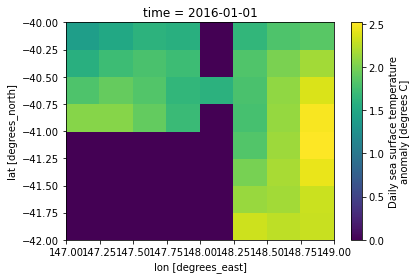

In [76]:
ssta.isel(time=0).plot()

Using the stacked latlon locations of coastal cells to find the location of the neighbouring cells in the ssta dataset, which I now call 'localcells'

In [33]:
# the ssta dataset has a resolution of 0.25 degrees; plus/minus 0.3 ensures that the selections overlaps, accounting for
# any shift between the two grids 

for (lat, lon) in coast_sel_stacked.latlon.values:
    centre = ssta.sel(lat=lat, lon=lon, method='nearest')
    centre_lat = centre.lat.values
    centre_lon = centre.lon.values
    localcells = ssta.sel(lat=slice(centre_lat-0.3,centre_lat+0.3), lon=slice(centre_lon-0.3,centre_lon+0.3))
   

In [52]:
localcells

<xarray.DataArray 'ssta' (time: 1096, lat: 3, lon: 3)>
dask.array<getitem, shape=(1096, 3, 3), dtype=float32, chunksize=(1096, 3, 3), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 -42.12 -41.88 -41.62
  * time     (time) datetime64[ns] 2016-01-01 2016-01-02 ... 2018-12-31
  * lon      (lon) float64 148.4 148.6 148.9
Attributes:
    units:      degrees C
    long_name:  Daily sea surface temperature anomaly

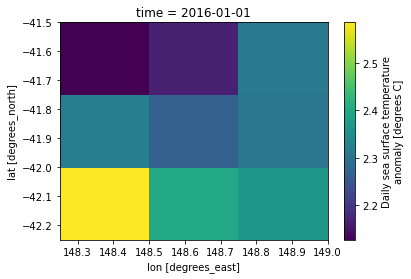

In [64]:
localcells.isel(time=0).plot()

In [45]:
for (lat, lon) in coast_sel_stacked.latlon.values:
    centre = tasa.sel(latitude=lat, longitude=lon, method='nearest')
    centre_lat = centre.latitude.values
    centre_lon = centre.longitude.values
    landcells = anom.sel(latitude=centre_lat, longitude=centre_lon)
    

In [46]:
landcells

<xarray.DataArray 'anomaly' (time: 1096)>
array([ 1.301403, -0.021752, -0.05137 , ...,  1.970779,  1.665073,  2.264326],
      dtype=float32)
Coordinates:
    longitude  float32 148.5
    latitude   float32 -42.0
  * time       (time) datetime64[ns] 2016-01-01 2016-01-02 ... 2018-12-31

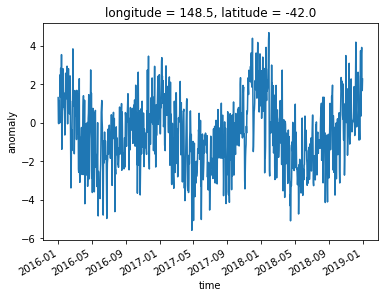

In [53]:
landcells.plot()

In [56]:
#noaa_mask = xr.open_dataset('/g/data/e14/cp3790/Charuni/lsmask.nc').sel(lon=slice(147.0, 149.0), lat=slice(-40.0, -42.0))
#mask = xr.where(ds.lsm==0, 0, 1)

# 1 degree resolution, so this wouldn't work 

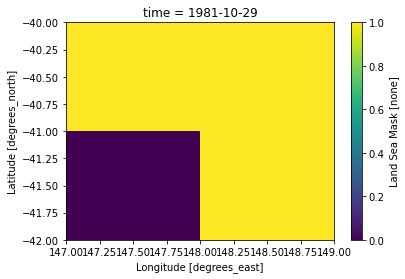

In [58]:
#noaa_mask.mask.plot()

In [132]:
#coast_sel_stacked.unstack().reindex(longitude=sorted(coast_grids.longitude))

<xarray.DataArray 'lsm' (time: 13514, latitude: 9, longitude: 9)>
array([[[nan, nan,  1., ...,  1., nan, nan],
        [nan, nan, nan, ...,  1., nan, nan],
        [nan, nan, nan, ...,  1., nan, nan],
        ...,
        [ 1., nan, nan, ...,  1., nan, nan],
        [ 1., nan, nan, ...,  1., nan, nan],
        [ 1.,  1.,  1., ...,  1., nan, nan]],

       [[nan, nan,  1., ...,  1., nan, nan],
        [nan, nan, nan, ...,  1., nan, nan],
        [nan, nan, nan, ...,  1., nan, nan],
        ...,
        [ 1., nan, nan, ...,  1., nan, nan],
        [ 1., nan, nan, ...,  1., nan, nan],
        [ 1.,  1.,  1., ...,  1., nan, nan]],

       [[nan, nan,  1., ...,  1., nan, nan],
        [nan, nan, nan, ...,  1., nan, nan],
        [nan, nan, nan, ...,  1., nan, nan],
        ...,
        [ 1., nan, nan, ...,  1., nan, nan],
        [ 1., nan, nan, ...,  1., nan, nan],
        [ 1.,  1.,  1., ...,  1., nan, nan]],

       ...,

       [[nan, nan,  1., ...,  1., nan, nan],
        [nan, nan, nan, ...,  1., nan, nan],
        [nan, nan, nan, ...,  1., nan, nan],
        ...,
        [ 1., nan, nan, ...,  1., nan, nan],
        [ 1., nan, nan, ...,  1., nan, nan],
        [ 1.,  1.,  1., ...,  1., nan, nan]],

       [[nan, nan,  1., ...,  1., nan, nan],
        [nan, nan, nan, ...,  1., nan, nan],
        [nan, nan, nan, ...,  1., nan, nan],
        ...,
        [ 1., nan, nan, ...,  1., nan, nan],
        [ 1., nan, nan, ...,  1., nan, nan],
        [ 1.,  1.,  1., ...,  1., nan, nan]],

       [[nan, nan,  1., ...,  1., nan, nan],
        [nan, nan, nan, ...,  1., nan, nan],
        [nan, nan, nan, ...,  1., nan, nan],
        ...,
        [ 1., nan, nan, ...,  1., nan, nan],
        [ 1., nan, nan, ...,  1., nan, nan],
        [ 1.,  1.,  1., ...,  1., nan, nan]]])
Coordinates:
  * longitude  (longitude) float64 147.0 147.2 147.5 147.8 ... 148.5 148.8 149.0
  * time       (time) object 1982-01-01 1982-01-02 ... 2018-12-30 2018-12-31
  * latitude   (latitude) float64 -40.0 -40.25 -40.5 ... -41.5 -41.75 -42.0

In [82]:
for (lat, lon) in coast_sel_stacked.latlon.values:
    cen = anom.sel(latitude=lat, longitude=lon, method='nearest')
    centre = ssta.sel(lat=lat, lon=lon, method='nearest')
    cen_lat = cen.latitude.values
    centre_lat = centre.lat.values
    cen_lon = cen.longitude.values
    centre_lon = centre.lon.values
    landcells = anom.sel(latitude=cen_lat, longitude=cen_lon)
    localcells = ssta.sel(lat=slice(centre_lat-0.3,centre_lat+0.3), lon=slice(centre_lon-0.3,centre_lon+0.3))

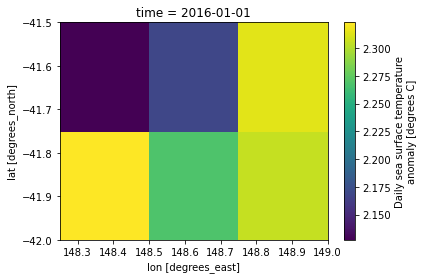

In [83]:
# Now I have to determine which localcells have valid ssta values 
localcells.isel(time=0).plot()